# Load AlphaMissense score

## Setup

In [40]:
!pip install biopandas datatable py3Dmol

In [64]:
import pandas as pd
import datatable as dt
from datatable import f
from biopandas.pdb import PandasPdb
import subprocess
import py3Dmol

In [65]:
def query_uniprot(df, #datatable
                  uniprot_id):
    braf = df.query(f'uniprot_id == "{uniprot_id}"').reset_index(drop=True) # if input is df
    # braf = DT[f.uniprot_id == uniprot_id, :].to_pandas() # if input is datatable
    braf[['aa1', 'position', 'aa2']] = braf['protein_variant'].str.extract(r'(\D)(\d+)(\D)')
    braf['position_aa'] = braf['aa1'] + braf['position']
    braf_p = braf.pivot(columns='position_aa',index='aa2',values='am_pathogenicity')
    columns = sorted(braf_p.columns, key=lambda x: int(x[1:]) if x[1:].isdigit() else -1)
    braf_p = braf_p[columns]
    return braf, braf_p

In [66]:
def read_pdb(fn):
    pdb = PandasPdb()
    df=pdb.read_pdb(fn).df['ATOM'].drop(columns=['line_idx'])
    return df

In [67]:
def df2string(df, fn=None):
    pdb_string = ''

    for index, row in df.iterrows():
        pdb_line = f"{row['record_name']:<6}{row['atom_number']:>5} {row['atom_name']:^4} {row['residue_name']:<3} {row['chain_id']:<1}{row['residue_number']:>4}    {row['x_coord']:>8.3f}{row['y_coord']:>8.3f}{row['z_coord']:>8.3f}{row['occupancy']:>6.2f}{row['b_factor']:>6.2f}          {row['element_symbol']:<2}\n"
        pdb_string += pdb_line
        
    if fn is not None:
        with open(fn,'w') as f:
            f.write(pdb_string)

    return pdb_string

In [68]:
def plot_protein(pdb_string):
    
    # with open("/content/AF-P15056-F1-model_v4.pdb") as ifile:
    #     protein = "".join([x for x in ifile])
    
    view = py3Dmol.view(width=800, height=600)
    view.addModelsAsFrames(pdb_string)

    # Use the color scheme based on b_factor for the cartoon representation
    style = {'cartoon': {'color': 'spectrum'}}

    view.setStyle({'model': -1}, style)

    view.zoom(0.12)
    view.show()

## Load AM Data

Download the AlphaMissense aa substitution data

In [69]:
# !wget https://storage.googleapis.com/dm_alphamissense/AlphaMissense_aa_substitutions.tsv.gz

# df = pd.read_csv('AlphaMissense_aa_substitutions.tsv.gz', compression='gzip',  header=3, sep='\t', quotechar='"')

# df.to_parquet('AlphaMissense_aa_substitutions.gzip.parquet', compression='gzip')

In [4]:
%%time
df = pd.read_parquet('AlphaMissense_aa_substitutions.gzip.parquet')

CPU times: user 1min 16s, sys: 17.2 s, total: 1min 34s
Wall time: 1min 9s


In [71]:
# Datatable can read much faster, but it is 7x size bigger than the parquet file (i.e. 7.9G vs. 1.3G)
# dt.Frame(df).to_jay("AlphaMissense_aa_substitutions.jay")

# DT = dt.fread("AlphaMissense_aa_substitutions.jay")

Only human protein uniprot id is available

In [72]:
uniprot_id = "P15056"

In [73]:
braf, braf_p = query_uniprot(df, uniprot_id)

In [74]:
braf.head()

,uniprot_id,protein_variant,am_pathogenicity,am_class,aa1,position,aa2,position_aa
0,P15056,M1A,0.4161,ambiguous,M,1,A,M1
1,P15056,M1C,0.4648,ambiguous,M,1,C,M1
2,P15056,M1D,0.9470,pathogenic,M,1,D,M1
3,P15056,M1E,0.8794,pathogenic,M,1,E,M1
4,P15056,M1F,0.3059,benign,M,1,F,M1


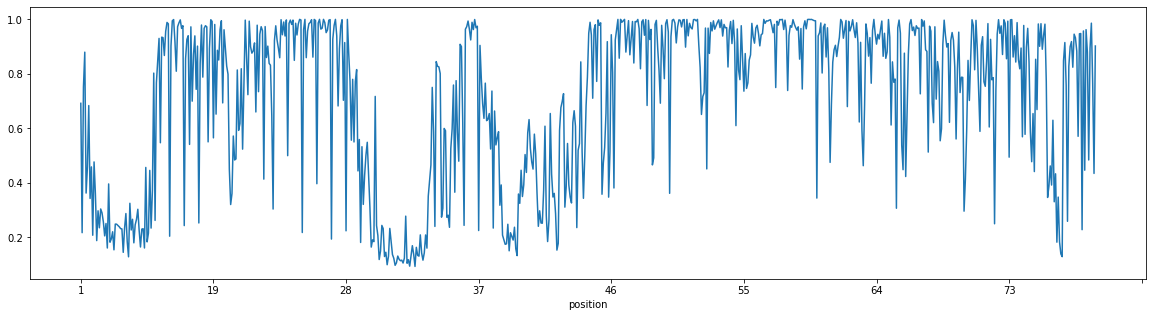

In [75]:
braf.groupby('position').am_pathogenicity.mean().plot.line(figsize=(20,5));

In [76]:
# This is a pivot table
braf_p.head()

position_aa,M1,A2,A3,L4,S5,G6,G7,G8,G9,G10,...,A757,G758,G759,Y760,G761,A762,F763,P764,V765,H766
aa2,,,,,,,,,,,,,,,,,,,,,
A,0.4161,NaN,NaN,0.1381,0.0814,0.0866,0.0876,0.0862,0.0769,0.0744,...,NaN,0.1272,0.1170,0.2643,0.1275,NaN,0.2161,0.0587,0.0781,0.0958
C,0.4648,0.8514,0.7150,0.4444,0.1360,0.1588,0.1583,0.1368,0.1265,0.1279,...,0.3173,0.2438,0.1658,0.1165,0.2445,0.2095,0.2275,0.2233,0.2322,0.1263
D,0.9470,0.8642,0.8135,0.6475,0.4370,0.3221,0.2415,0.2339,0.1992,0.1899,...,0.5152,0.5681,0.4761,0.3122,0.4080,0.1154,0.4131,0.1852,0.1357,0.1096
E,0.8794,0.7726,0.7313,0.4440,0.4063,0.2903,0.2109,0.1838,0.1571,0.1521,...,0.5048,0.5310,0.4139,0.4754,0.3844,0.0929,0.4273,0.1596,0.1262,0.1061
F,0.3059,0.8798,0.7296,0.1564,0.3792,0.4320,0.3555,0.3121,0.2807,0.2782,...,0.4170,0.6456,0.5086,0.0721,0.6015,0.2351,NaN,0.3118,0.0711,0.1474


In [77]:
am_mean = pd.DataFrame(braf.groupby('position')\
                       .am_pathogenicity.mean())\
                        .reset_index()\
                        .rename(columns={'position':'residue_number'})

In [78]:
am_mean.residue_number = am_mean.residue_number.astype('int64')

## Replace b_factor with AM score in pdb file to visualize

In [79]:
url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"

subprocess.run(["wget", url])

--2023-09-22 15:05:06--  https://alphafold.ebi.ac.uk/files/AF-P15056-F1-model_v4.pdb
Resolving alphafold.ebi.ac.uk (alphafold.ebi.ac.uk)... 34.149.152.8
Connecting to alphafold.ebi.ac.uk (alphafold.ebi.ac.uk)|34.149.152.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘AF-P15056-F1-model_v4.pdb’

     0K .......... .......... .......... .......... .......... 19.4M
    50K .......... .......... .......... .......... .......... 30.0M
   100K .......... .......... .......... .......... .......... 24.3M
   150K .......... .......... .......... .......... .......... 44.7M
   200K .......... .......... .......... .......... .......... 42.9M
   250K .......... .......... .......... .......... .......... 42.7M
   300K .......... .......... .......... .......... .......... 52.9M
   350K .......... .......... .......... .......... .......... 80.7M
   400K .......... .......... .......... .......... .......... 85.9M
   4

CompletedProcess(args=['wget', 'https://alphafold.ebi.ac.uk/files/AF-P15056-F1-model_v4.pdb'], returncode=0)

In [80]:
# If it is AF structure
pdb = read_pdb(f'AF-{uniprot_id}-F1-model_v4.pdb')

In [81]:
# If it is rscb structure
# pdb = read_pdb('7upi.pdb')

# pdb = pdb.query('chain_id=="C"').reset_index(drop=True)

In [82]:
pdb = pdb.merge(am_mean)

In [83]:
pdb['b_factor'] = pdb.am_pathogenicity # replace b_factor score with am score

In [84]:
# string = df2string(pdb,f'AM_7upi.pdb')

In [85]:
string = df2string(pdb,f'AM_{uniprot_id}.pdb')

In [86]:
plot_protein(string)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Download the output pdb file, open pdb file in ChimeraX, and type "color byattribute bfactor" in command to visualize AM score

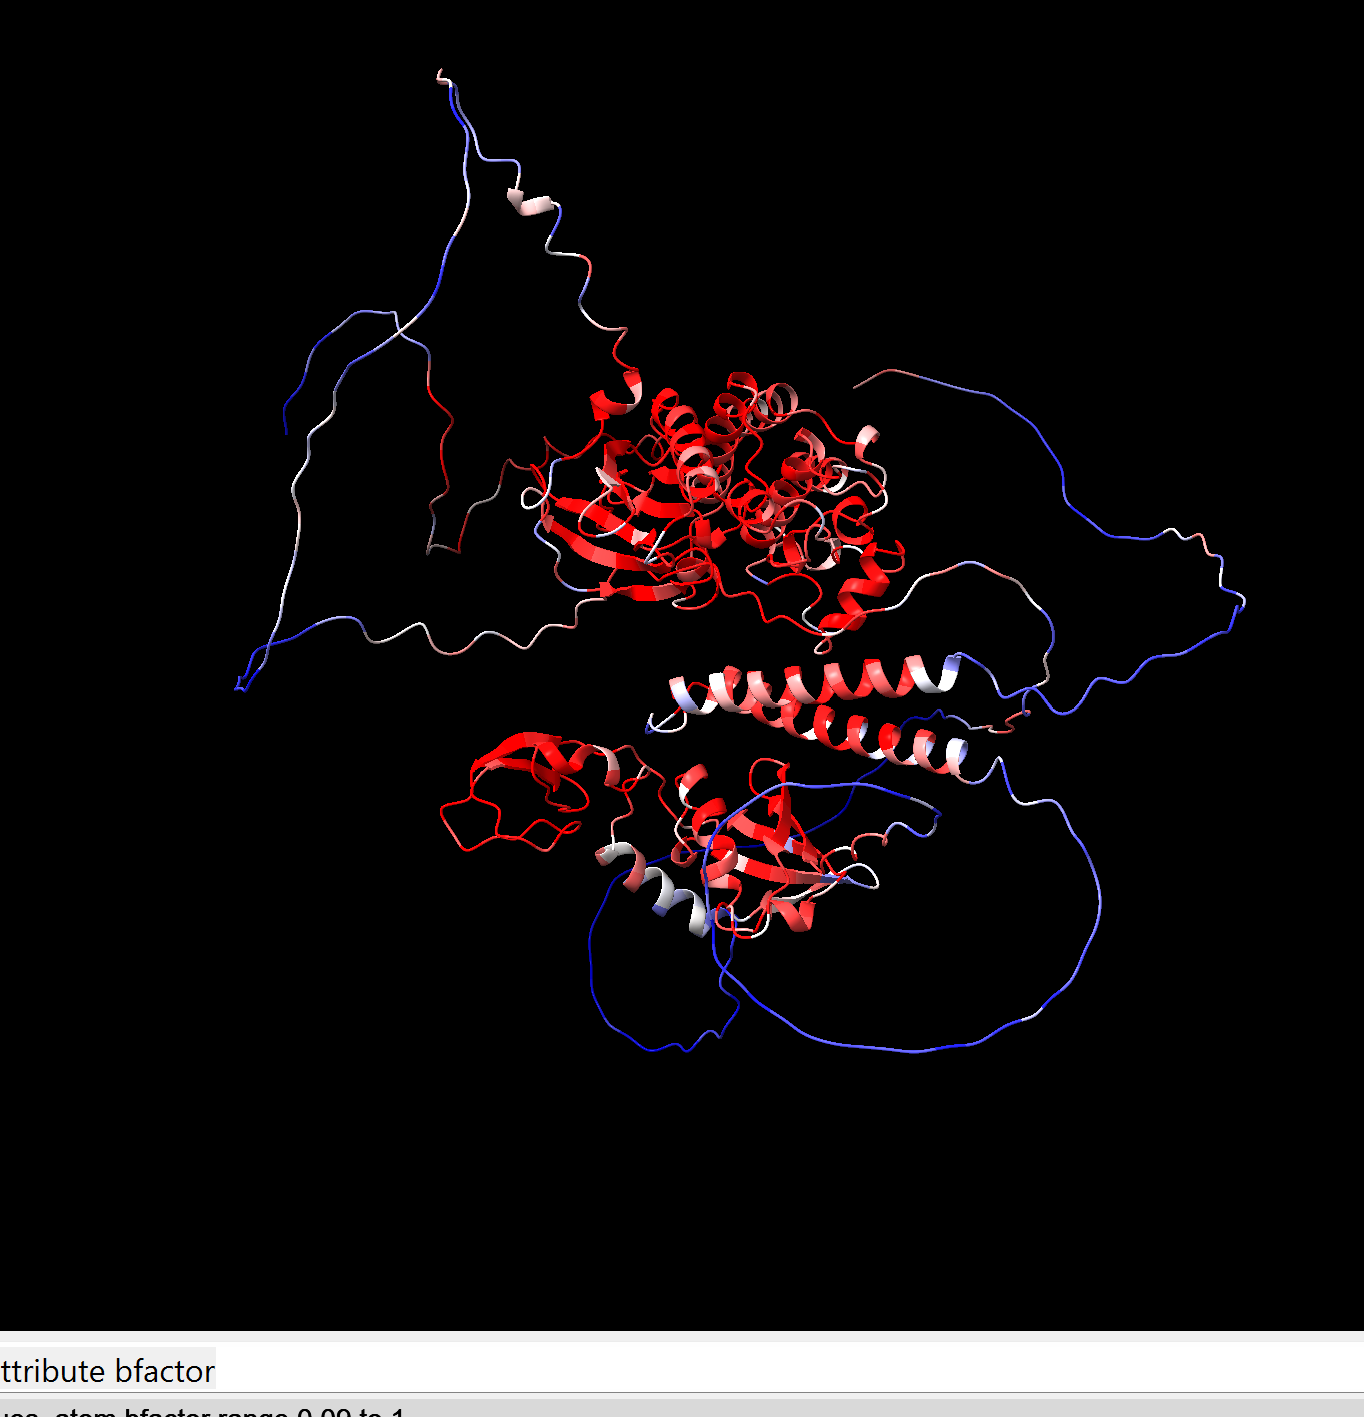